#### Import packages

In [1]:
# import torch.multiprocessing as mp
# mp.set_start_method('spawn') 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import shutil
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import random
import cv2

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tensorboardX import SummaryWriter
import torch.utils.data
import torch.utils.data as data_utils

seed = 0
# random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
np.random.seed(seed)
# from utils_3 import *
# from utils import *
from utils_diff_ch import *

#### Load and Prepare Data

In [2]:
data = pd.read_json('./Data/train.json')
test = pd.read_json('./Data/test.json')

In [3]:
data['band_1'] = data['band_1'].apply(lambda x : np.array(x).reshape(75, 75))
data['band_2'] = data['band_2'].apply(lambda x : np.array(x).reshape(75, 75))

test['band_1'] = test['band_1'].apply(lambda x : np.array(x).reshape(75, 75))
test['band_2'] = test['band_2'].apply(lambda x : np.array(x).reshape(75, 75))

data['inc_angle'] = pd.to_numeric(data['inc_angle'], errors='coerce')
test['inc_angle'] = pd.to_numeric(test['inc_angle'], errors='coerce')

In [4]:
# Impute missing incidence angles
data_impute = data.dropna(axis=0, how='any')
data_impute_b1 = np.array([im.reshape(75*75) for im in data_impute.loc[:,'band_1']])
data_impute_b2 = np.array([im.reshape(75*75) for im in data_impute.loc[:,'band_2']])
data_impute_X = np.hstack(np.array((data_impute_b1, data_impute_b2, data_impute[['is_iceberg']])))
data_impute_y = np.array(data_impute[['inc_angle']])

data_impute_prec = data[~data.index.isin(data_impute.index.values)]
data_impute_b1_prec = np.array([im.reshape(75*75) for im in data_impute_prec.loc[:,'band_1']])
data_impute_b2_prec = np.array([im.reshape(75*75) for im in data_impute_prec.loc[:,'band_2']])
data_impute_X_prec = np.hstack(np.array((data_impute_b1_prec, data_impute_b2_prec, data_impute_prec[['is_iceberg']])))

modelImpute = LinearRegression()
modelImpute = modelImpute.fit(data_impute_X, data_impute_y)
data_impute_prec['inc_angle'] = modelImpute.predict(data_impute_X_prec)

data.loc[data_impute_prec.index] = data_impute_prec

/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
def scale_range (input_, min_, max_):
    input_ += -(np.min(input_))
    input_ /= np.max(input_) / (max_ - min_)
    input_ += min_
    return input_

In [6]:
train, val = train_test_split(data, test_size=0.2, random_state=42)
band_1_tr = np.concatenate([im for im in train['band_1']]).reshape(-1, 75, 75)
band_2_tr = np.concatenate([im for im in train['band_2']]).reshape(-1, 75, 75)
X_train = np.stack((band_1_tr, band_2_tr), axis=1)
X_train = [X_train, np.array(train['inc_angle']).reshape((len(train), 1))]

band_1_val = np.concatenate([im for im in val['band_1']]).reshape(-1, 75, 75)
band_2_val = np.concatenate([im for im in val['band_2']]).reshape(-1, 75, 75)
X_val = np.stack((band_1_val, band_2_val), axis=1)
X_val = [X_val, np.array(val['inc_angle']).reshape((len(val), 1))]

band_1_test = np.concatenate([im for im in test['band_1']]).reshape(-1, 75, 75)
band_2_test = np.concatenate([im for im in test['band_2']]).reshape(-1, 75, 75)
# band_3_test = scale_range(band_1_test/band_2_test, -1, 1)
rgb = np.stack((band_1_test, band_2_test), axis=1)
X_test = [rgb, np.array(test['inc_angle']).reshape((len(test), 1))]

y_train = train['is_iceberg'].values.astype(np.float32)
y_val = val['is_iceberg'].values.astype(np.float32)

#### PyTorch Model

In [7]:
# Hyper Parameters
width = 75
height = 75
channels = 2
padding = 0
batch_size = 32

In [8]:
# Data Loader (Input Pipeline)
class icebergDataset(data_utils.Dataset):
    """Iceberg-Ship dataset."""

    def __init__(self, X, y=None, transform=None):
        self.X_images = X[0]
        self.X_angles = torch.from_numpy(X[1]).float()
        if y!=None:
            self.y = torch.from_numpy(y.reshape((len(y),1))).float()
        else:
            self.y=None
        self.transform = transform

    def __len__(self):
        return len(self.X_images)

    def __getitem__(self, idx):
        im = self.X_images[idx]
        if self.transform:
#             if np.random.random() < 0.2:
#                 im = cv2.blur(im, (2,2))
            im = randomErodeDilate(im, u=0.3)
            im = randomZoomOut(im, u=0.5)
            im = randomNoisy(im, u=0.4)
            im = randomShift(im, u=0.4)
            im = randomRotation(im, u=0.4)
#             if np.random.random() < 0.5:
#                 im = np.flip(im, 1).copy()
#             if np.random.random() < 0.5:
#                 im = np.flip(im, 2).copy()
            
        try:
            if self.y==None:
                return [torch.from_numpy(im).float(), self.X_angles[idx]]
        except:
            pass
            
        return [torch.from_numpy(im).float(), self.X_angles[idx], self.y[idx]]

In [10]:
def save_checkpoint(state, is_best, filename='./Models/checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, './Models/model_best.pth.tar')

In [11]:
train_dataset = icebergDataset(X_train, y_train, transform=True)
val_dataset = icebergDataset(X_val, y_val)
test_dataset = icebergDataset(X_test)

/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [33]:
act = nn.PReLU()
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.batch = nn.BatchNorm2d(channels)
        self.batch1D = nn.BatchNorm1d(1)
        self.layer1 = nn.Sequential(
            nn.Conv2d(channels, 18, kernel_size=1, padding=padding),
            nn.BatchNorm2d(18),
            act,
            nn.Conv2d(18, 18, kernel_size=3, padding=padding),
            nn.BatchNorm2d(18),
            act,
            nn.Conv2d(18, 18, kernel_size=3, padding=padding),
            nn.BatchNorm2d(18),
            act,
            nn.MaxPool2d(2),
            nn.Dropout(0.25))
        self.layer2 = nn.Sequential(
            nn.Conv2d(18, 36, kernel_size=3, padding=padding),
            nn.BatchNorm2d(36),
            act,
            nn.Conv2d(36, 54, kernel_size=3, padding=padding),
            nn.BatchNorm2d(54),
            act,
            nn.MaxPool2d(2),
            nn.Dropout(0.25))
        self.layer3 = nn.Sequential(
            nn.Conv2d(54, 72, kernel_size=2, padding=padding),
            nn.BatchNorm2d(72),
            act,
            nn.MaxPool2d(2),
            nn.Dropout(0.2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(72, 144, kernel_size=2, padding=padding),
            nn.BatchNorm2d(144),
            act,
            nn.MaxPool2d(2),
            nn.Dropout(0.25))
        self.layer_shallow = nn.Sequential(
            nn.Conv2d(channels, 128, kernel_size=3, padding=padding),
            nn.BatchNorm2d(128),
            act,
            nn.MaxPool2d(2),
            nn.Dropout(0.25))
        self.fc1 = nn.Sequential(
            nn.Linear(1+(3*3*144), 512),
            act,
            nn.Dropout(0.5))
        self.fc2 = nn.Sequential(
            nn.Linear(512, 196),
            act,
            nn.Dropout(0.5))
        self.fc3 = nn.Linear(196, 1)
        self.sig = nn.Sigmoid()
        
        
    def forward(self, x_im, x_angle):
        x_angle = self.batch1D(x_angle)
#         x_angle_ch = x_im*torch.sin(x_angle).expand(75,75,x_angle.size(0),2).contiguous().view(x_angle.size(0), 2, height, width)
#         x_im = torch.cat([x_im, x_angle_ch], dim=1)
#         x_third_ch = (x_im[:,0,:,:]/x_im[:,1,:,:]).view(x_im.size(0), 1, height, width)
#         x_im = torch.cat([x_im, x_third_ch], dim=1)
        x_im = self.batch(x_im)
        out = self.layer1(x_im)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
#         out_shallow = self.layer_shallow(x_im)
#         out_shallow  = F.max_pool2d(out_shallow, kernel_size=out_shallow.size()[2:])
#         out_shallow = out_shallow.view(out_shallow.size(0), -1)
        out = torch.cat([out, x_angle], dim=1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [34]:
def weight_init(m): 
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight.data)
    if isinstance(m, nn.Linear):
        torch.nn.init.orthogonal(m.weight.data)

In [35]:
writer = SummaryWriter()
iceNet = net()
iceNet.apply(weight_init).cuda()

net (
  (batch): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True)
  (batch1D): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True)
  (layer1): Sequential (
    (0): Conv2d(2, 18, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True)
    (2): PReLU (1)
    (3): Conv2d(18, 18, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True)
    (5): PReLU (1)
    (6): Conv2d(18, 18, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True)
    (8): PReLU (1)
    (9): LPPool2d (
    )
    (10): Dropout (p = 0.2)
  )
  (layer2): Sequential (
    (0): Conv2d(18, 36, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True)
    (2): PReLU (1)
    (3): Conv2d(36, 54, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(54, eps=1e-05, momentum=0.1, affine=True)
    (5): PReLU (1)
    (6): LPPool2d (
    )
    (7): Dropout (p = 0.2)

In [36]:
num_epochs = 500
batch_size = 64
learning_rate = 0.0005

In [37]:
# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(iceNet.parameters(), lr=1e-2, momentum=0.9, nesterov=True, weight_decay=1e-6)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

def accuracy(loader):
    iceNet.eval()
    correct = 0
    total = 0
    loss = []
    for features, features_angle, labels in loader:
        features = features.cuda()
        labels = labels.cuda()
        features_angle = features_angle.cuda()
        features = Variable(features, volatile=True)
        features_angle = Variable(features_angle, volatile=True)
        labels = Variable(labels, volatile=True).float()
        outputs = iceNet(features, features_angle)
        _loss = criterion(outputs, labels)
        loss.append(_loss)
        predicted = (F.sigmoid(outputs).data>0.5)
        total += labels.size(0)
        correct += (predicted == labels.byte().data).sum()
        
    return np.mean(loss).data[0], (100 * correct / total)

In [38]:
# Train the Model
loss_plot = []
best_prec1 = 1
for epoch in range(num_epochs):
    epoch_train_loss = []
    for i, (features, features_angle, labels) in enumerate(train_loader):
        iceNet.train()
        features = features.cuda()
        labels = labels.cuda()
        features = Variable(features).float()
        features_angle = Variable(features_angle).cuda()
        labels = Variable(labels).float()
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = iceNet(features, features_angle)
        writer.add_graph(iceNet, outputs)
#         writer.add_histogram('hist_fc1', iceNet.features_1[1].weight.data.cpu().numpy(), i)
#         writer.add_histogram('hist_fc2', iceNet.features_1[3].weight.data.cpu().numpy(), i)
#         writer.add_histogram('hist_fc3', iceNet.features_2.weight.data.cpu().numpy(), i)
        loss = criterion(outputs, labels)
        epoch_train_loss.append(loss)
        loss.backward()
        optimizer.step()
        
    acc = accuracy(val_loader)
    prec1 = acc[0]
    tr_loss = np.mean(epoch_train_loss).data[0]
    loss_plot.append([prec1, tr_loss])
    print ('Epoch [%d/%d] \nTraining Loss: %.4f' % (epoch+1, num_epochs, tr_loss))
    print('Validation Loss: %.4f, Accuracy: %.2f%%' % acc)
    
    is_best = prec1 < best_prec1
    best_prec1 = min(prec1, best_prec1)
#     save_checkpoint({
#         'epoch': epoch + 1,
#         'state_dict': iceNet.state_dict(),
#         'best_prec1': best_prec1,
#         'optimizer' : optimizer.state_dict(),
#     }, is_best)

print(best_prec1)
# export scalar data to JSON for external processing
writer.close()

Epoch [1/500] 
Training Loss: 0.6808
Validation Loss: 0.6883, Accuracy: 61.06%
Epoch [2/500] 
Training Loss: 0.6553
Validation Loss: 0.6717, Accuracy: 62.62%
Epoch [3/500] 
Training Loss: 0.6284
Validation Loss: 0.7564, Accuracy: 51.09%
Epoch [4/500] 
Training Loss: 0.6341
Validation Loss: 0.5626, Accuracy: 73.21%
Epoch [5/500] 
Training Loss: 0.5799
Validation Loss: 0.4579, Accuracy: 76.01%
Epoch [6/500] 
Training Loss: 0.5175
Validation Loss: 0.3970, Accuracy: 76.32%
Epoch [7/500] 
Training Loss: 0.5309
Validation Loss: 0.3970, Accuracy: 77.88%
Epoch [8/500] 
Training Loss: 0.4972
Validation Loss: 0.4939, Accuracy: 69.78%
Epoch [9/500] 
Training Loss: 0.5131
Validation Loss: 0.6012, Accuracy: 70.72%
Epoch [10/500] 
Training Loss: 0.5148
Validation Loss: 0.5773, Accuracy: 59.19%
Epoch [11/500] 
Training Loss: 0.5168
Validation Loss: 0.4414, Accuracy: 73.83%
Epoch [12/500] 
Training Loss: 0.5202
Validation Loss: 0.4033, Accuracy: 77.88%
Epoch [13/500] 
Training Loss: 0.4911
Validation 

Epoch [104/500] 
Training Loss: 0.5686
Validation Loss: 0.6647, Accuracy: 60.44%
Epoch [105/500] 
Training Loss: 0.5447
Validation Loss: 0.5658, Accuracy: 70.09%
Epoch [106/500] 
Training Loss: 0.5120
Validation Loss: 0.3356, Accuracy: 81.62%
Epoch [107/500] 
Training Loss: 0.5263
Validation Loss: 0.3182, Accuracy: 81.31%
Epoch [108/500] 
Training Loss: 0.4494
Validation Loss: 0.3018, Accuracy: 82.87%
Epoch [109/500] 
Training Loss: 0.4251
Validation Loss: 0.2784, Accuracy: 85.67%
Epoch [110/500] 
Training Loss: 0.3870
Validation Loss: 0.2890, Accuracy: 84.74%
Epoch [111/500] 
Training Loss: 0.4299
Validation Loss: 0.3095, Accuracy: 83.49%
Epoch [112/500] 
Training Loss: 0.4148
Validation Loss: 0.2795, Accuracy: 85.36%
Epoch [113/500] 
Training Loss: 0.4284
Validation Loss: 0.2674, Accuracy: 86.92%
Epoch [114/500] 
Training Loss: 0.4184
Validation Loss: 0.2612, Accuracy: 86.60%
Epoch [115/500] 
Training Loss: 0.4312
Validation Loss: 0.3134, Accuracy: 83.80%
Epoch [116/500] 
Training Lo

Epoch [206/500] 
Training Loss: 0.3379
Validation Loss: 0.2353, Accuracy: 88.16%
Epoch [207/500] 
Training Loss: 0.3621
Validation Loss: 0.2314, Accuracy: 88.79%
Epoch [208/500] 
Training Loss: 0.3553
Validation Loss: 0.2438, Accuracy: 88.16%
Epoch [209/500] 
Training Loss: 0.3673
Validation Loss: 0.2490, Accuracy: 87.23%
Epoch [210/500] 
Training Loss: 0.3197
Validation Loss: 0.2333, Accuracy: 87.85%
Epoch [211/500] 
Training Loss: 0.3278
Validation Loss: 0.2395, Accuracy: 86.92%
Epoch [212/500] 
Training Loss: 0.3777
Validation Loss: 0.2162, Accuracy: 90.34%
Epoch [213/500] 
Training Loss: 0.3734
Validation Loss: 0.2390, Accuracy: 88.79%
Epoch [214/500] 
Training Loss: 0.4193
Validation Loss: 0.2473, Accuracy: 88.47%
Epoch [215/500] 
Training Loss: 0.3790
Validation Loss: 0.2189, Accuracy: 90.03%
Epoch [216/500] 
Training Loss: 0.3980
Validation Loss: 0.2412, Accuracy: 88.16%
Epoch [217/500] 
Training Loss: 0.3796
Validation Loss: 0.2351, Accuracy: 88.79%
Epoch [218/500] 
Training Lo

Epoch [308/500] 
Training Loss: 0.3318
Validation Loss: 0.2152, Accuracy: 89.10%
Epoch [309/500] 
Training Loss: 0.3600
Validation Loss: 0.2528, Accuracy: 87.23%
Epoch [310/500] 
Training Loss: 0.3895
Validation Loss: 0.2352, Accuracy: 90.34%
Epoch [311/500] 
Training Loss: 0.3870
Validation Loss: 0.2799, Accuracy: 85.67%
Epoch [312/500] 
Training Loss: 0.3457
Validation Loss: 0.2377, Accuracy: 88.47%
Epoch [313/500] 
Training Loss: 0.4315
Validation Loss: 0.5612, Accuracy: 72.59%
Epoch [314/500] 
Training Loss: 0.3648
Validation Loss: 0.2580, Accuracy: 86.60%
Epoch [315/500] 
Training Loss: 0.3554
Validation Loss: 0.2094, Accuracy: 89.72%
Epoch [316/500] 
Training Loss: 0.4943
Validation Loss: 0.2208, Accuracy: 89.10%
Epoch [317/500] 
Training Loss: 0.4388
Validation Loss: 0.2597, Accuracy: 85.98%
Epoch [318/500] 
Training Loss: 0.3818
Validation Loss: 0.2077, Accuracy: 90.65%
Epoch [319/500] 
Training Loss: 0.3577
Validation Loss: 0.2098, Accuracy: 90.97%


KeyboardInterrupt: 

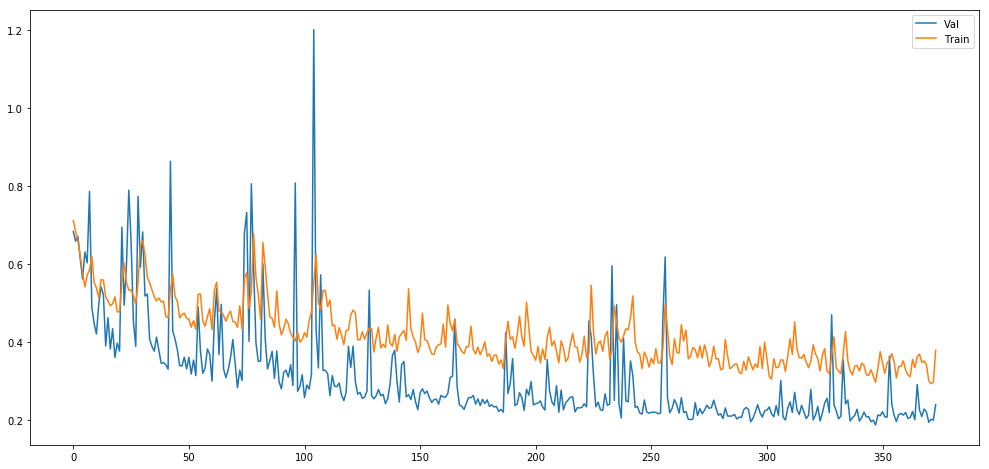

0.18835914134979248


In [27]:
plt.figure(figsize=(17,8))
plt.plot(loss_plot)
plt.legend(['Val', 'Train'])
plt.show()
print(best_prec1)

In [85]:
print("=> loading checkpoint")
best_model = torch.load('./Models/model_best.pth.tar')
print('best_prec1 = ', best_model['best_prec1'])
iceNet.load_state_dict(best_model['state_dict'])
optimizer.load_state_dict(best_model['optimizer'])

=> loading checkpoint
best_prec1 =  0.19683799147605896


KeyError: 'missing keys in state_dict: "{\'layer1.9.weight\', \'layer1.9.bias\'}"'

In [124]:
temp_dataset = icebergDataset(X_train)

In [129]:
# Predict
iceNet.eval()
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
results = []
for features, features_angle in test_loader:
    iceNet.eval()
    features = Variable(features, volatile=True).cuda()
    features_angle = Variable(features_angle, volatile=True).cuda()
    outputs = F.softmax(iceNet(features, features_angle))
#     outputs = iceNet(features, features_angle)

    results.append(outputs.data[0][1])

In [132]:
sub = pd.read_csv('./Data/sample_submission.csv')

In [133]:
sub['is_iceberg'] = results

In [135]:
sub.to_csv('./Submissions/sub_30Oct_val_1631.csv', index=False)

#### KFold

In [28]:
def scale_test_range (input_, train_min, train_max, min_, max_):
    input_ += -(train_min)
    input_ /= train_max / (max_ - min_)
    input_ += min_
    return input_

def std_test_range (input_, mean, sd):
    input_ -= mean
    input_ /= sd
    return input_

In [29]:
def weight_init(m): 
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight.data)
    if isinstance(m, nn.Linear):
        torch.nn.init.orthogonal(m.weight.data)

In [30]:
band_1_KF = np.concatenate([im for im in data['band_1']]).reshape(-1, 75, 75)
band_2_KF = np.concatenate([im for im in data['band_2']]).reshape(-1, 75, 75)
# band_3_KF = scale_range(band_1_KF/band_2_KF, -1, 1)
X_KF = np.stack((band_1_KF, band_2_KF), axis=1)
X_KF = [X_KF, np.array(data['inc_angle']).reshape((len(data), 1))]

# X_test[0] = scale_test_range(X_test[0], train_min, train_max, -1, 1)
y_KF = data['is_iceberg'].values.astype(np.float32)

In [31]:
def accuracy(loader):
    iceNet.eval()
    correct = 0
    total = 0
    loss = []
    predicted_val = []
    for features, features_angle, labels in loader:
        features = Variable(features, volatile=True).cuda()
        features_angle = Variable(features_angle, volatile=True).cuda()
        labels = Variable(labels, volatile=True).cuda().float()
        outputs = iceNet(features, features_angle)
        predicted_val.append(outputs.data[:].cpu().numpy())
        _loss = criterion(outputs, labels)
        loss.append(_loss)
        predicted = (F.sigmoid(outputs).data>0.5)
        total += labels.size(0)
        correct += (predicted == labels.byte().data).sum()
    return np.mean(loss).data[0], (100 * correct / total), np.concatenate(predicted_val)

In [32]:
num_epochs = 1200
batch_size = 64
learning_rate = 0.0005

In [33]:
kfold = 5
kfold_scores = []

test_dataset = icebergDataset(X_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

results = []
fold_predictions = []
sss = KFold(n_splits=kfold, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X_KF[0], X_KF[1], y_KF)):
    X_train_KF, X_valid_KF = [X_KF[0][train_index], X_KF[1][train_index]], [X_KF[0][test_index], X_KF[1][test_index]]
    y_train_KF, y_valid_KF = y_KF[train_index], y_KF[test_index]
    
    # Define model
    iceNet = net().apply(weight_init).cuda()
    
    # Loss and Optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(iceNet.parameters(), lr=learning_rate, weight_decay=0.0001)
    
    # Data Loader
    train_dataset_KF = icebergDataset(X_train_KF, y_train_KF, transform=True)
    val_dataset_KF = icebergDataset(X_valid_KF, y_valid_KF)

    train_loader_KF = torch.utils.data.DataLoader(dataset=train_dataset_KF, batch_size=batch_size, shuffle=True)
    val_loader_KF = torch.utils.data.DataLoader(dataset=val_dataset_KF, batch_size=batch_size, shuffle=False)
    
    print('Fold [%d/%d]' % (i+1, kfold))
    # Train
    best_prec1 = 1
    for epoch in range(num_epochs):
        epoch_train_loss = []
        for idx, (features, features_angle, labels) in enumerate(train_loader_KF):
            iceNet.train()
            features = Variable(features).cuda()
            features_angle = Variable(features_angle).cuda()
            labels = Variable(labels).cuda().float()
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = iceNet(features, features_angle)
            loss = criterion(outputs, labels)
            epoch_train_loss.append(loss)
            loss.backward()
            optimizer.step()

        acc = accuracy(val_loader_KF)
        prec1 = acc[0]

        # Save best model
        is_best = prec1 < best_prec1
        best_prec1 = min(prec1, best_prec1)
        if is_best:
            best_fold_predictions = acc[2]
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': iceNet.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict(),
        }, is_best, filename='./Models/v1Nov_v1/model_fold_'+str(i+1)+'.pth.tar')
        
    print('Val Score : %f' % (best_prec1))
    fold_predictions.append(best_fold_predictions)
    kfold_scores.append(best_prec1)
    # Load best model
    best_model = torch.load('./Models/v1Nov_v1/model_fold_'+str(i+1)+'.pth.tar')
    iceNet.load_state_dict(best_model['state_dict'])
    optimizer.load_state_dict(best_model['optimizer'])
    
    # Predict
    iceNet.eval()
    
    results_fold = []
    for features, features_angle in test_loader:
        iceNet.eval()
        features = Variable(features, volatile=True).cuda()
        features_angle = Variable(features_angle, volatile=True).cuda()
        outputs = F.sigmoid(iceNet(features, features_angle))
    #     outputs = iceNet(features, features_angle)

        results_fold.append(outputs.data.cpu().numpy()[0][0])        
    
    results.append(np.array(results_fold))

/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Fold [1/5]
Val Score : 0.168701
Fold [2/5]
Val Score : 0.163382
Fold [3/5]
Val Score : 0.202774
Fold [4/5]
Val Score : 0.143680
Fold [5/5]


KeyboardInterrupt: 

In [19]:
np.array(kfold_scores).mean()

0.1679735541343689

In [21]:
np.array(kfold_scores).std()

0.026696076294194737

In [20]:
np.array(sub['is_iceberg']<0.5).sum()

NameError: name 'sub' is not defined

In [22]:
sub_num = 47
os.makedirs("./Models/Sub "+str(sub_num))
np.savetxt("./Models/Sub "+str(sub_num)+"/results.csv", np.array(results), delimiter=",")
np.savetxt("./Models/Sub "+str(sub_num)+"/cv_fold_results.csv", np.concatenate(fold_predictions), delimiter=",")
sub = pd.read_csv('./Data/sample_submission.csv')
sub['is_iceberg'] = np.array(results).mean(axis=0)
sub.to_csv('./Submissions/Sub '+str(sub_num)+' - 5-fold _ Val-1679.csv', index=False)

In [6]:
sub = pd.read_csv('./Data/sample_submission.csv')

In [55]:
overall_sub_num = 39
ensemble_subs = [31,32,35,36,22]
ensemble_results = []
for sub_num in ensemble_subs:
    ensemble_results.append(np.loadtxt('./Models/Sub '+str(sub_num)+'/results.csv', delimiter=','))
    
ensemble_results = np.prod(np.concatenate(ensemble_results), axis=0)**(1/(5*len(ensemble_subs)))

sub = pd.read_csv('./Data/sample_submission.csv')
sub['is_iceberg'] = ensemble_results
sub.to_csv('./Submissions/Sub '+str(overall_sub_num)+' - fold_model_ensemble-'+'_'.join(map(str, ensemble_subs))+'.csv',
           index=False)

In [7]:
sub1 = pd.read_csv('./Submissions/Sub 3 - 5 fold _ Val - 0.1504.csv')['is_iceberg']
sub2 = pd.read_csv('./Submissions/Sub 5 - 5-fold _ Val-1538.csv')['is_iceberg']
sub3 = pd.read_csv('./Submissions/Sub 6 - 5-fold _ Val-1480.csv')['is_iceberg']
sub4 = pd.read_csv('./Submissions/Sub 8 - 5-fold _ Val-1479.csv')['is_iceberg']
sub5 = pd.read_csv('./Submissions/Sub 16 - 5-fold _ Val-1422.csv')['is_iceberg']
sub6 = pd.read_csv('./Submissions/Sub 22 - 5-fold _ Val-1571.csv')['is_iceberg']
sub7 = pd.read_csv('./Submissions/Sub 25 - 5-fold _ Val-1757.csv')['is_iceberg']
sub8 = pd.read_csv('./Submissions/Sub 35 - 5-fold _ Val-1715.csv')['is_iceberg']
sub9 = pd.read_csv('./Submissions/Sub 36 - 5-fold _ Val-1661.csv')['is_iceberg']
sub10 = pd.read_csv('./Submissions/Sub 43 - 5-fold _ Val-1673.csv')['is_iceberg']
sub11 = pd.read_csv('./Submissions/Sub 45 - 5-fold _ Val-1795.csv')['is_iceberg']
sub12 = pd.read_csv('./Submissions/Sub 46 - 5-fold _ Val-1563.csv')['is_iceberg']
sub13 = pd.read_csv('./Submissions/Sub 47 - 5-fold _ Val-1679.csv')['is_iceberg']
sub14 = pd.read_csv('./Submissions/Sub 48 - 5-fold _ Val-1583.csv')['is_iceberg']
sub15 = pd.read_csv('./Submissions/Sub 51 - 5-fold _ Val-1525.csv')['is_iceberg']
sub16 = pd.read_csv('./Submissions/Sub 52 - 5-fold _ Val-1594.csv')['is_iceberg']
sub17 = pd.read_csv('./Submissions/Sub 53 - 5-fold _ Val-1685.csv')['is_iceberg']
sub18 = pd.read_csv('./Submissions/Sub 54 - 5-fold _ Val-1670.csv')['is_iceberg']

In [8]:
results = 1/np.mean((1/np.array(sub1), 1/np.array(sub2), 1/np.array(sub3), 1/np.array(sub4), 1/np.array(sub5),
                   1/np.array(sub6), 1/np.array(sub7), 1/np.array(sub8), 1/np.array(sub9), 1/np.array(sub10),
                    1/np.array(sub11), 1/np.array(sub12), 1/np.array(sub13), 1/np.array(sub14),
                    1/np.array(sub15), 1/np.array(sub16), 1/np.array(sub17), 1/np.array(sub18)), axis=0)
sub['is_iceberg'] = np.array(results)
sub.to_csv('./Submissions/Sub 55 - Ensemble of 18 models - Harmonic Mean.csv', index=False)

#### Error Analysis

In [24]:
def accuracy(loader):
    iceNet.eval()
    correct = 0
    total = 0
    loss = []
    inc_features = []
    inc_feature_angles = []
    inc_labels = []
    for features, features_angle, labels in loader:
        features = Variable(features, volatile=True).cuda()
        features_angle = Variable(features_angle, volatile=True).cuda()
        labels = Variable(labels, volatile=True).cuda()
        outputs = iceNet(features, features_angle)
        _loss = criterion(outputs, labels)
        loss.append(_loss)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
        inc_features.append(features.data.cpu().numpy()[np.where((predicted!=labels.data).cpu().numpy())])
        inc_feature_angles.append(features_angle.data.cpu().numpy()[np.where((predicted!=labels.data).cpu().numpy())])
        inc_labels.append(labels.data.cpu().numpy()[np.where((predicted!=labels.data).cpu().numpy())])
        
    return np.mean(loss).data[0], (100 * correct / total), [inc_features, inc_feature_angles, inc_labels]

In [25]:
kfold = 5
kfold_scores = []

results = []
sss = KFold(n_splits=kfold, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X_KF[0], X_KF[1], y_KF)):
    if i == 2:
        X_train_KF, X_valid_KF = [X_KF[0][train_index], X_KF[1][train_index]], [X_KF[0][test_index], X_KF[1][test_index]]
        y_train_KF, y_valid_KF = y_KF[train_index], y_KF[test_index]

        # Define model
        iceNet = net().apply(weight_init).cuda()

        # Loss and Optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(iceNet.parameters(), lr=learning_rate, weight_decay=0.0001)

        # Data Loader
        train_dataset_KF = icebergDataset(X_train_KF, y_train_KF, transform=True)
        val_dataset_KF = icebergDataset(X_valid_KF, y_valid_KF)

        train_loader_KF = torch.utils.data.DataLoader(dataset=train_dataset_KF, batch_size=batch_size, shuffle=True)
        val_loader_KF = torch.utils.data.DataLoader(dataset=val_dataset_KF, batch_size=batch_size, shuffle=False)

        print('Fold [%d/%d]' % (i+1, kfold))
        # Train
        best_prec1 = 1
        for epoch in range(num_epochs):
            epoch_train_loss = []
            for idx, (features, features_angle, labels) in enumerate(train_loader_KF):
                iceNet.train()
                features = Variable(features).cuda()
                features_angle = Variable(features_angle).cuda()
                labels = Variable(labels).cuda()
                # Forward + Backward + Optimize
                optimizer.zero_grad()
                outputs = iceNet(features, features_angle)
                loss = criterion(outputs, labels)
                epoch_train_loss.append(loss)
                loss.backward()
                optimizer.step()
            
            acc = accuracy(val_loader_KF)
            prec1 = acc[0]

            # Save best model
            is_best = prec1 < best_prec1
            best_prec1 = min(prec1, best_prec1)
            if is_best:
                incorrect = acc[2]
print(best_prec1)

/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Fold [3/5]
0.2119673639535904


In [26]:
incorrect[0] = np.vstack(incorrect[0])
incorrect[1] = np.vstack(incorrect[1])
incorrect[2] = np.hstack(incorrect[2])

In [46]:
def randomZoomOut(im, zoom_ratio=(-0.5, 0.5), u=0.5):
    if np.random.random() < u:
        height, width = im[0].shape
        
        zoom = height*np.random.uniform(zoom_ratio[0], zoom_ratio[1])
        if int(zoom)<0:
            zoom = abs(int(zoom))
            im_0 = cv2.resize(im[0, zoom//2:-zoom//2, zoom//2:-zoom//2], (height, width))
            im_1 = cv2.resize(im[1, zoom//2:-zoom//2, zoom//2:-zoom//2], (height, width))
#            im_2 = cv2.resize(im[2, zoom//2:-zoom//2, zoom//2:-zoom//2], (height, width))
#            im_3 = cv2.resize(im[3, zoom//2:-zoom//2, zoom//2:-zoom//2], (height, width))
            return np.stack((im_0,im_1))
        
        if zoom<0:
            zoom = 0
        im_0 = cv2.resize(cv2.copyMakeBorder(im[0],int(zoom//2),int(zoom//2),int(zoom//2),int(zoom//2),
                                   cv2.BORDER_REFLECT101), (height, width))
        im_1 = cv2.resize(cv2.copyMakeBorder(im[1],int(zoom//2),int(zoom//2),int(zoom//2),int(zoom//2),
                                   cv2.BORDER_WRAP), (height, width))
#        im_2 = cv2.resize(cv2.copyMakeBorder(im[2],int(zoom//2),int(zoom//2),int(zoom//2),int(zoom//2),
#                                   cv2.BORDER_REPLICATE), (height, width))
#        im_3 = cv2.resize(cv2.copyMakeBorder(im[3],int(zoom//2),int(zoom//2),int(zoom//2),int(zoom//2),
#                                   cv2.BORDER_REPLICATE), (height, width))
        return np.stack((im_0,im_1))
    
    return im

In [47]:
for idx, im in enumerate(incorrect[0]):
    f, axarr = plt.subplots(2, 2, figsize=(10,8))
    plt.title('Label = '+str(incorrect[2][idx])+', Inc Angle = '+str(incorrect[1][idx][0]))
    zm = randomZoomOut(im, (0, 0.5), 1)
    axarr[0, 0].imshow(im[0], cmap='gray')
    axarr[0, 1].imshow(im[1], cmap='gray')
    axarr[1, 0].imshow(zm[0], cmap='gray')
    axarr[1, 1].imshow(zm[1], cmap='gray')
    plt.show()

error: /home/travis/miniconda/conda-bld/conda_1486587069159/work/opencv-3.1.0/modules/core/src/copy.cpp:928: error: (-5) Unknown/unsupported border type in function borderInterpolate
